# Test NN reweighting

Ok, so I tried playing with my own pytorch implementation, but for some reason the training wasn't stable. I wasn't sure what was up with my implementation, so I'll continue debugging this later - but for now I'm going to try out Lucas's function `getNNweights` to see if I can start getting limits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
import uproot

from scipy.optimize import least_squares

import os
os.sys.path.append('../eda_tools')
from NN_RW import getNNweights
from plot_helper import reweightedHist

os.sys.path.append('../code')
from plotting import cf_1d_dists

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Running w/ conda env: don't import root packages.


In [2]:
filename="/u/ki/nhartman/gpfs/hh4b-resolved-reconstruction/data16_topo_2016triggers.root"
tree = uproot.open(filename)["fullmassplane"]

data16 = tree.pandas.df()

In [3]:
to_log = [ 'pT_4', 'pT_2', 'dRjj_1', 'dRjj_2', 'pt_hh' ]
for tl in to_log:
    data16[tl+'_log'] = np.log(data16[tl])

**I should add a patience to the training!**

Load in the trained model!

In [5]:
ws = getNNweights(data16,train=True)

Instructions for updating:
Use tf.cast instead.
Train on 1256911 samples, validate on 314228 samples
Epoch 1/50
1256911/1256911 [==============================] - 15s 12us/step - loss: 0.1947 - acc: 1.7583e-04 - val_loss: 0.1496 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.14958, saving model to nn_rw//current_model.h5
Epoch 2/50
1256911/1256911 [==============================] - 14s 11us/step - loss: 0.1488 - acc: 0.0000e+00 - val_loss: 0.1479 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.14958 to 0.14791, saving model to nn_rw//current_model.h5
Epoch 3/50
1256911/1256911 [==============================] - 29s 23us/step - loss: 0.1480 - acc: 0.0000e+00 - val_loss: 0.1470 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.14791 to 0.14700, saving model to nn_rw//current_model.h5
Epoch 4/50
1256911/1256911 [==============================] - 34s 27us/step - loss: 0.1476 - acc: 0.0000e+00 - val_loss: 0.1482 - val_acc: 0.0000e+00

Epoch 00004

array([[0.0046622 ],
       [0.01844891],
       [0.00403861],
       ...,
       [0.00979523],
       [0.01118537],
       [0.00488928]], dtype=float32)

Make plots

1561725


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


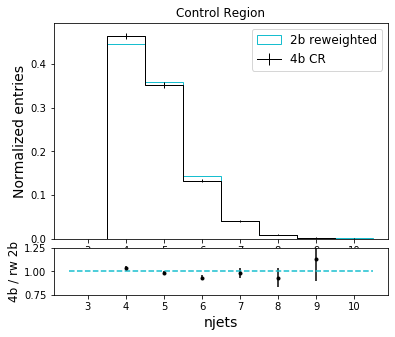

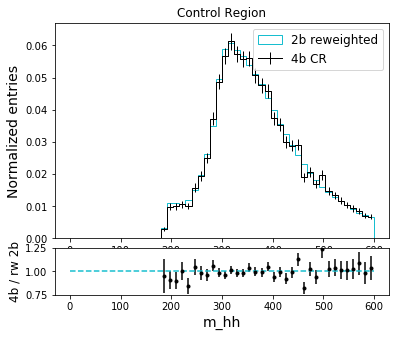

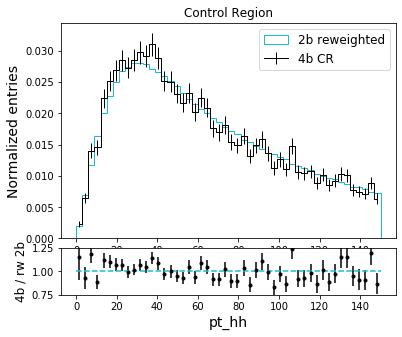

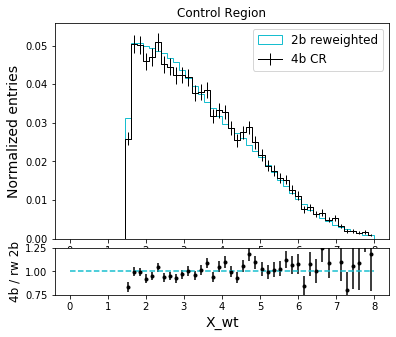

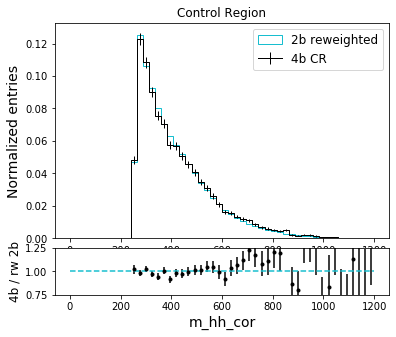

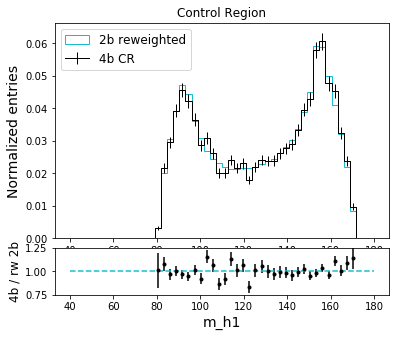

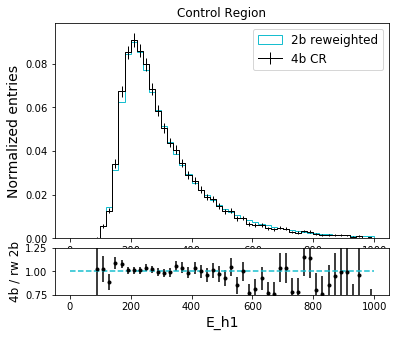

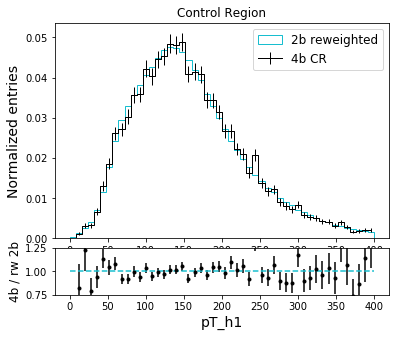

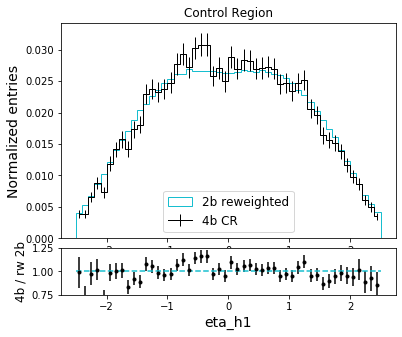

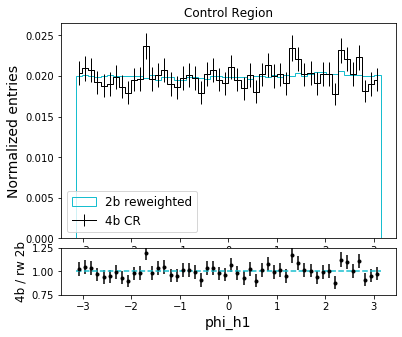

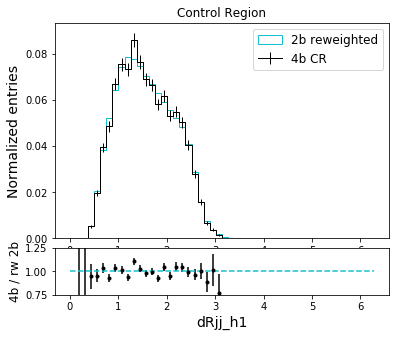

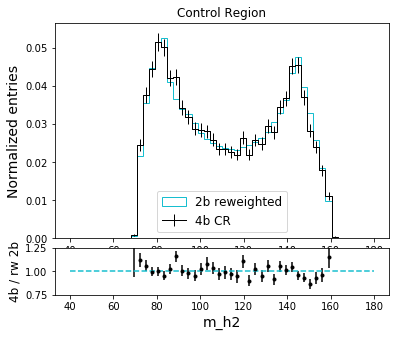

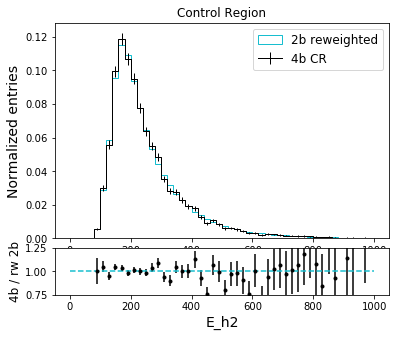

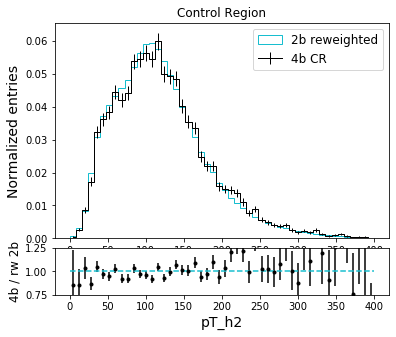

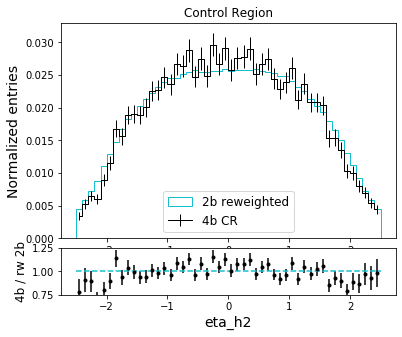

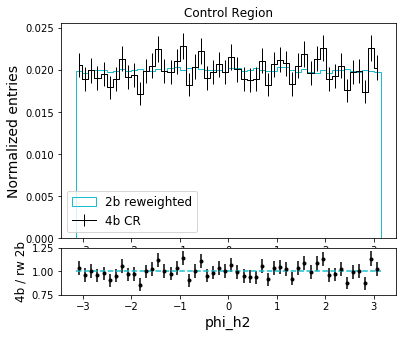

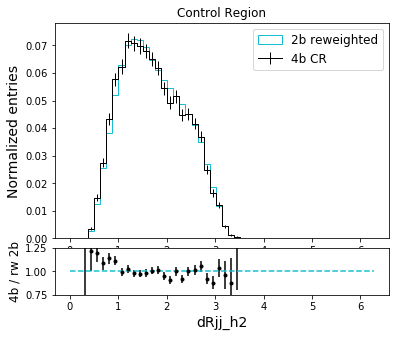

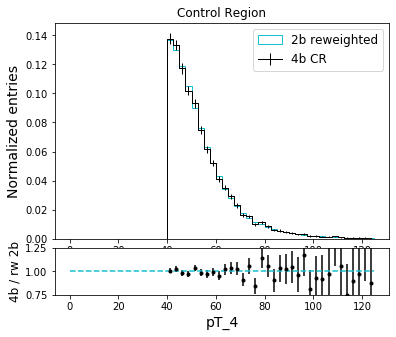

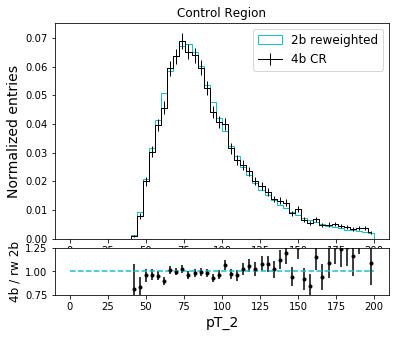

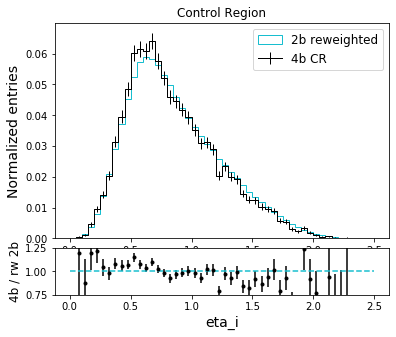

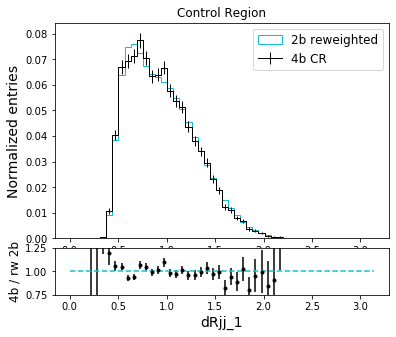

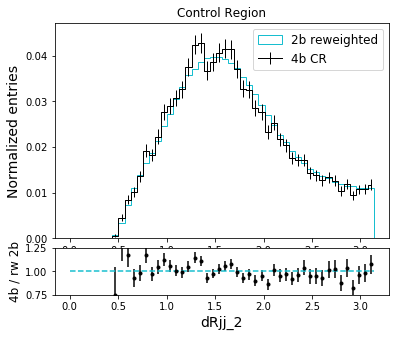

In [6]:
cf_1d_dists(data16,drawUnweighted=False,mask=(data16.kinematic_region==2),
            title='Control Region',chi2Only=False,w2b='NN_w_2b')

In [7]:
# plotCols = ['njets','eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh','m_hh']
# myRanges = [(3.5,12.5),(-2.5,2.5),(0,400),(0,200),(0,np.pi),(0,2*np.pi),(0,500),(0,1250)]

# nBinsCont = 50
# nBins = [9] + [nBinsCont]*(len(myRanges)-1)

# for c,b,r in zip(plotCols,nBins,myRanges):
    
#     reweightedHist(data16,kinematic_region=2,feature=c,weight_column='NN_w_2b',
#                    color='C9',bins=b,range=r,xlabel=c)

Rafael liked the space between the subfigures, so I'm going to stick with my code for the plots for my next talks.

Ok, this is *awesome*, I trust this NN reweighting code.

## Now train with pairAGraph

### Just after the pairing


In [8]:
nSelectedJets = 5

sigSubDir = 'SMNR_mc16a_PFlow-AUG2019'
bkgSubDir = 'data_16_PFlow-MAY2019'

if nSelectedJets != 4:
    sigSubDir += f'-{nSelectedJets}jets'
    bkgSubDir += f'-{nSelectedJets}jets'

In [9]:
bFile = f"../data/{bkgSubDir}/df_f_0.22_NNT_HCs.h5"
bkg_df = pd.read_hdf(bFile,key='df')

bkg_df['deta_hh'] = np.abs(bkg_df.eta_h1-bkg_df.eta_h2)
for tl in to_log:
    bkg_df[tl+'_log'] = np.log(bkg_df[tl])

In [10]:
for k,s in zip([0,1,2],['SR','VR','CR']):
    print(s,'2b:',np.sum((data16.kinematic_region==k)&(data16.ntag==2)))
    if k == 0:
        continue
    print(s,'4b:',np.sum((data16.kinematic_region==k)&(data16.ntag>=4)))

SR 2b: 1077201
VR 2b: 1148500
VR 4b: 6688
CR 2b: 1561725
CR 4b: 9414


In [11]:
print('baseline:\n')
for k,s in zip([2,1,0],['CR','VR','SR']):
    N_2b = np.sum((data16.kinematic_region==k)&(data16.ntag==2))
    N_4b = np.sum((data16.kinematic_region==k)&(data16.ntag>=4))
    
    print('  ',s,'2b:',N_2b)
    if k == 0:
        continue
    print('  ',s,'4b:',N_4b)
    print('  ',s,'4b/2b:',N_4b/N_2b,'\n')

baseline:

   CR 2b: 1561725
   CR 4b: 9414
   CR 4b/2b: 0.006027949863132114 

   VR 2b: 1148500
   VR 4b: 6688
   VR 4b/2b: 0.0058232477144101 

   SR 2b: 1077201


In [12]:
print('pairAGraph:\n')
for k,s in zip([2,1,0],['CR','VR','SR']):
    N_2b = np.sum((bkg_df.kinematic_region==k)&(bkg_df.ntag==2))
    N_4b = np.sum((bkg_df.kinematic_region==k)&(bkg_df.ntag>=4))
    
    print('  ',s,'2b:',N_2b)
    if k == 0:
        continue
    print('  ',s,'4b:',N_4b)
    print('  ',s,'4b/2b:',N_4b/N_2b,'\n')

pairAGraph:

   CR 2b: 189959
   CR 4b: 15124
   CR 4b/2b: 0.079617180549487 

   VR 2b: 106864
   VR 4b: 8407
   VR 4b/2b: 0.07867008534211709 

   SR 2b: 75635


There's a lot more 4b events with pairAGraph!!!

In [13]:
(453311+39186)*.6

295498.2

In [14]:
modelDir = f"nn_rw/data_16_preXwt_pairAGraph_CR"
if not os.path.exists(modelDir):
    os.mkdir(modelDir)
hist = getNNweights(bkg_df,train=True,key='NN_w_2b',kinematic_region=2,modelDir=modelDir,
                    nHidden=10,patience=2)

Train on 164066 samples, validate on 41017 samples
Epoch 1/50
164066/164066 [==============================] - 2s 13us/step - loss: 0.7195 - acc: 0.0251 - val_loss: 0.5430 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.54302, saving model to nn_rw/data_16_preXwt_pairAGraph_CR/current_model.h5
Epoch 2/50
164066/164066 [==============================] - 1s 6us/step - loss: 0.5313 - acc: 0.0000e+00 - val_loss: 0.5250 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.54302 to 0.52499, saving model to nn_rw/data_16_preXwt_pairAGraph_CR/current_model.h5
Epoch 3/50
164066/164066 [==============================] - 1s 7us/step - loss: 0.5209 - acc: 0.0000e+00 - val_loss: 0.5186 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.52499 to 0.51860, saving model to nn_rw/data_16_preXwt_pairAGraph_CR/current_model.h5
Epoch 4/50
164066/164066 [==============================] - 1s 8us/step - loss: 0.5159 - acc: 0.0000e+00 - val_loss: 0.5147 - val_acc: 0.0000e+

Look at the plots in the CR before applying $X_{wt}$.

189959


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


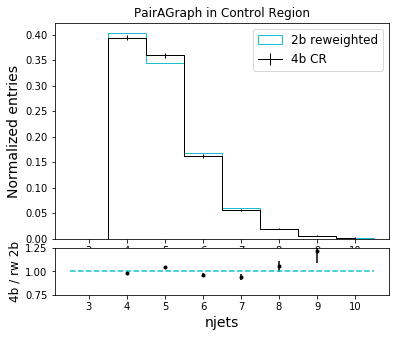

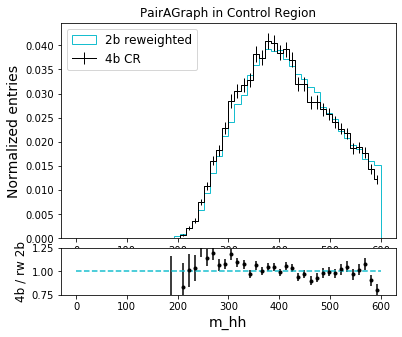

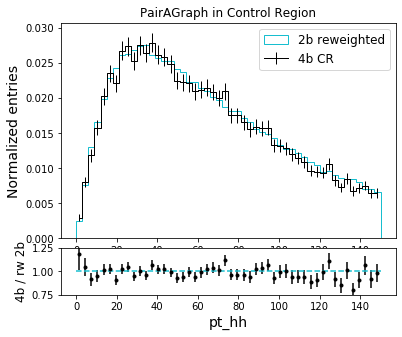

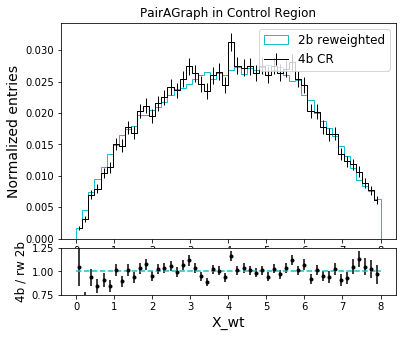

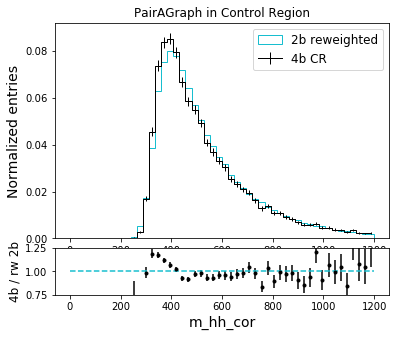

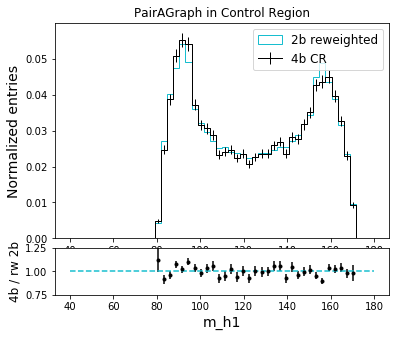

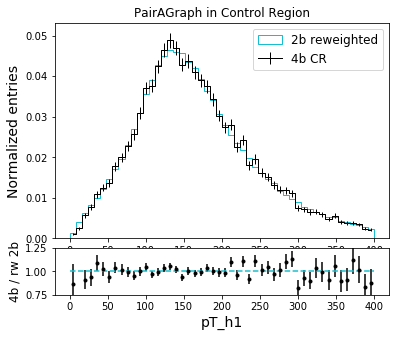

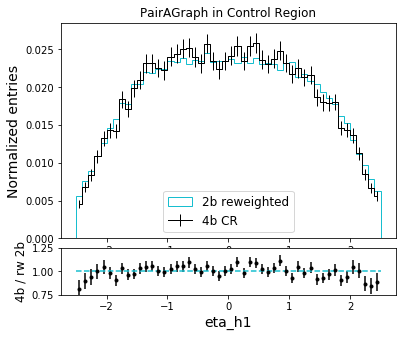

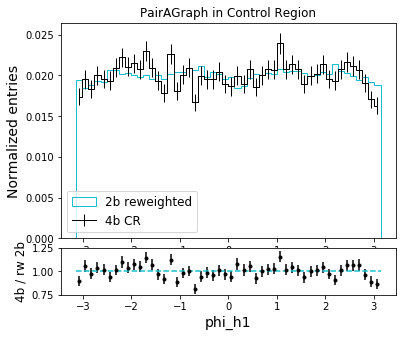

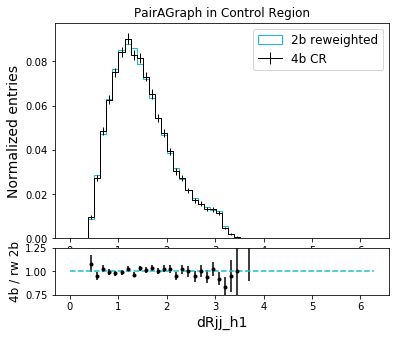

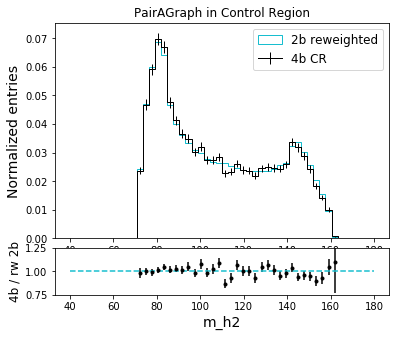

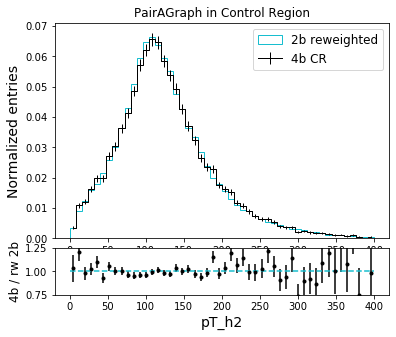

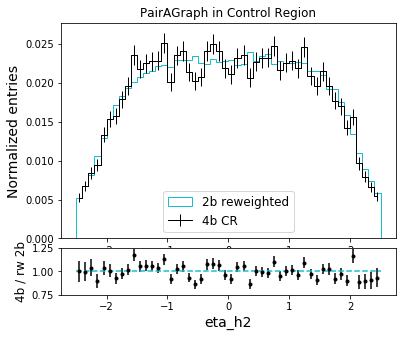

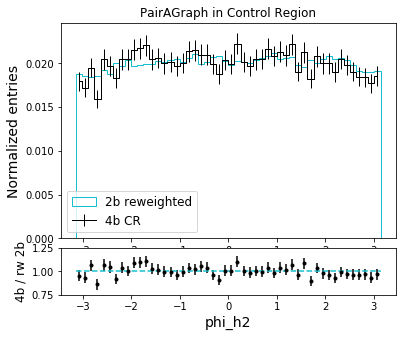

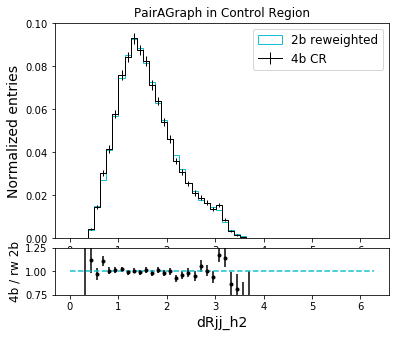

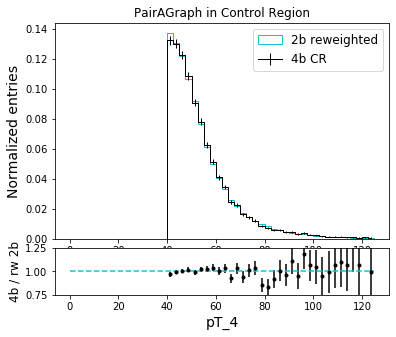

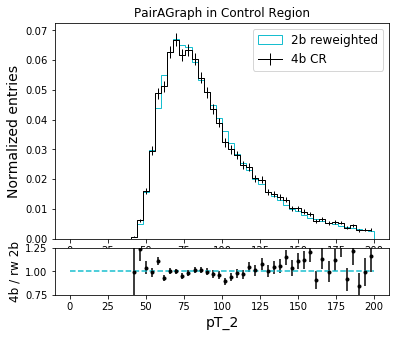

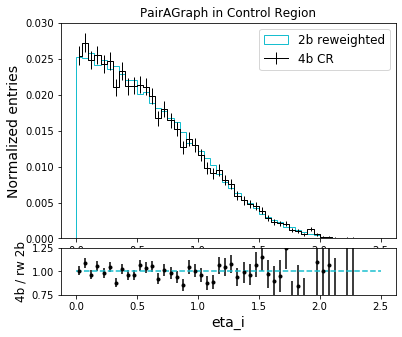

../code/plotting.py:760: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3369: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


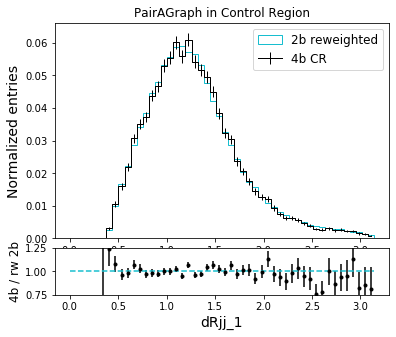

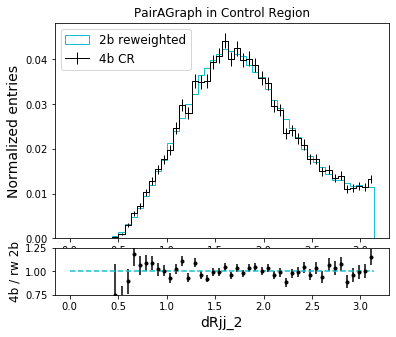

In [15]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=(bkg_df.kinematic_region==2),
            title='PairAGraph in Control Region',chi2Only=False,w2b='NN_w_2b')

Ok, this isn't good enough, I'm going to look at training the data_16 applying a cut on m_hh.

If this is bad, I should see if the background estimate is ok if we apply an $m_{hh}$ cut on the baseline Ntuples.

In [16]:
modelDir = f"nn_rw/data_16_NNT_m_hh>350GeV_CR"
if not os.path.exists(modelDir):
    os.mkdir(modelDir)
ws = getNNweights(data16[data16.m_hh>350],train=True,kinematic_region=2,modelDir=modelDir,
                    nHidden=20,patience=2,key='w_2b_mhh_cut')

data16.loc[data16.m_hh>350,'w_2b_mhh_cut']=ws

Train on 718848 samples, validate on 179712 samples
Epoch 1/50
718848/718848 [==============================] - 7s 9us/step - loss: 0.2114 - acc: 2.1006e-04 - val_loss: 0.1519 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.15187, saving model to nn_rw/data_16_NNT_m_hh>350GeV_CR/current_model.h5
Epoch 2/50
718848/718848 [==============================] - 6s 9us/step - loss: 0.1526 - acc: 0.0000e+00 - val_loss: 0.1475 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.15187 to 0.14748, saving model to nn_rw/data_16_NNT_m_hh>350GeV_CR/current_model.h5
Epoch 3/50
718848/718848 [==============================] - 8s 11us/step - loss: 0.1501 - acc: 0.0000e+00 - val_loss: 0.1467 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.14748 to 0.14665, saving model to nn_rw/data_16_NNT_m_hh>350GeV_CR/current_model.h5
Epoch 4/50
718848/718848 [==============================] - 8s 11us/step - loss: 0.1493 - acc: 0.0000e+00 - val_loss: 0.1464 - val_acc: 0.0000e+

KeyboardInterrupt: 

In [ ]:
data16.columns

In [ ]:
data16.loc[data16.m_hh>350,'w_2b_mhh_cut']=ws

In [ ]:
cf_1d_dists(data16[data16.m_hh>350],drawUnweighted=False,mask=(data16.kinematic_region==2),
            title='Baseline with $m_{hh}$ > 350 GeV: Control Region',chi2Only=False,w2b='w_2b_mhh_cut')

- Hmmmm, this $m_{hh}$ cut idn't account for the larger loss. 
- Rafael suggested that I try was train the baseline, but keep the 2b / 4b ratio 

In [ ]:
N_keep_2b = int(9414/.08644)
N_keep_2b

In [ ]:
mask_2b = (bkg_df.ntag == 2) & (bkg_df.kinematic_region == 2)
print(np.sum(mask_2b))
m = np.add.accumulate(mask_2b)
i = np.argmin(np.abs(m-N_keep_2b))
mask_2b[i+1:]=False
print(np.sum(mask_2b))

In [ ]:
modelDir = f"nn_rw/data_16_NNT_2b_to_4b_0.08"
if not os.path.exists(modelDir):
    os.mkdir(modelDir)
hist = getNNweights(data16,train=True,key='w_2b_classProp',kinematic_region=2,modelDir=modelDir,
                    nHidden=20,patience=2,N_keep_2b=N_keep_2b)

In [ ]:
cf_1d_dists(data16,drawUnweighted=False,mask=(data16.kinematic_region==2),
            title='Baseline using constant b fractions',chi2Only=False,w2b='w_2b_classProp')

**Question:** Does the modelling look better when I train with a BDT?

No, I already tried this.

Maybe these cuts in the SB were mostly just useful to get 2b to look more like 4b?

Look at the plots in the CR after applying $X_{wt}$.

Overlay the histograms and get a limit.

**For the systematic estimate, derive the background estimate in the VR**

In [ ]:
getNNweights(bkg_df,train=True,key='NN_w_2b_VR',kinematic_region=1)

Look at the plots in the VR

Loo

### First after the full analysis chain (but before $X_{wt}$)

In [ ]:
bkg_df.MDR

In [17]:
from preprocess import MDR_cut

In [18]:
# Apply the cuts up to Xwt
bkg_df['MDR'] = MDR_cut(bkg_df.dRjj_h1, bkg_df.dRjj_h2, bkg_df.m_hh)

bkg_df['lead_HC_pt'] = np.where(bkg_df.pT_h1>bkg_df.pT_h2, bkg_df.pT_h1, bkg_df.pT_h2)
bkg_df['subl_HC_pt'] = np.where(bkg_df.pT_h1>bkg_df.pT_h2, bkg_df.pT_h2, bkg_df.pT_h1)

lead_pT_cut = 0.5  * bkg_df.m_hh - 103
subl_pT_cut = 0.33 * bkg_df.m_hh -  73
bkg_df['MDpT'] = (bkg_df['lead_HC_pt'] > lead_pT_cut) & (bkg_df['lead_HC_pt'] > subl_pT_cut) & bkg_df.MDR

bkg_df['cut_deta_hh'] = (bkg_df.deta_hh < 1.5) & (bkg_df.MDpT)
bkg_df['cut_Xwt'] = (bkg_df.X_wt > 1.5) #& (bkg_df.cut_deta_hh)

In [19]:
modelDir = f"nn_rw/data_16_stdCuts_preXwt_CR"
if not os.path.exists(modelDir):
    os.mkdir(modelDir)
ws = getNNweights(bkg_df[bkg_df.cut_deta_hh],train=True,kinematic_region=2,modelDir=modelDir,
                    nHidden=20,patience=2,key='w_2b_stdCuts')

bkg_df.loc[bkg_df.cut_deta_hh,'w_2b_stdCuts']=ws

Train on 68687 samples, validate on 17172 samples
Epoch 1/50
68687/68687 [==============================] - 2s 24us/step - loss: 0.8678 - acc: 0.0662 - val_loss: 0.6317 - val_acc: 5.8234e-05

Epoch 00001: val_loss improved from inf to 0.63173, saving model to nn_rw/data_16_stdCuts_preXwt_CR/current_model.h5
Epoch 2/50
68687/68687 [==============================] - 1s 10us/step - loss: 0.5925 - acc: 0.0000e+00 - val_loss: 0.5790 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.63173 to 0.57901, saving model to nn_rw/data_16_stdCuts_preXwt_CR/current_model.h5
Epoch 3/50
68687/68687 [==============================] - 1s 12us/step - loss: 0.5729 - acc: 0.0000e+00 - val_loss: 0.5695 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.57901 to 0.56952, saving model to nn_rw/data_16_stdCuts_preXwt_CR/current_model.h5
Epoch 4/50
68687/68687 [==============================] - 1s 11us/step - loss: 0.5654 - acc: 0.0000e+00 - val_loss: 0.5632 - val_acc: 0.0000e+00

Epoch 00004

../eda_tools/NN_RW.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = R * N_4b / N_2b


78469


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


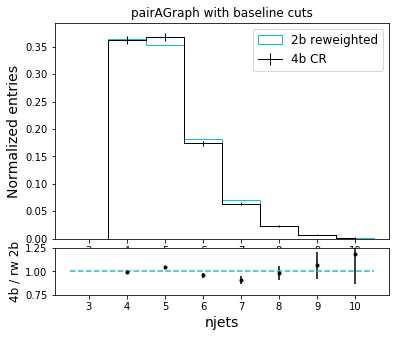

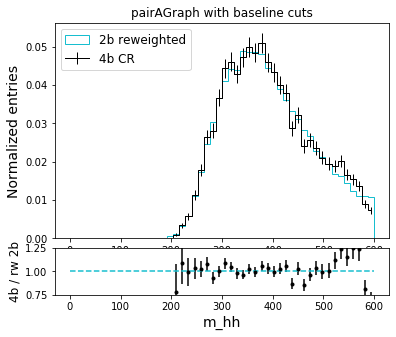

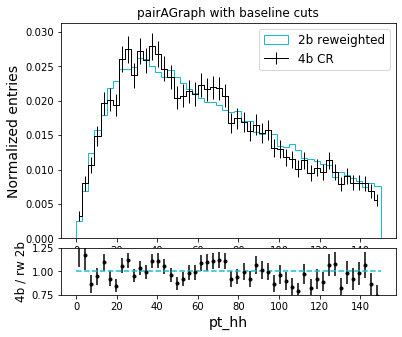

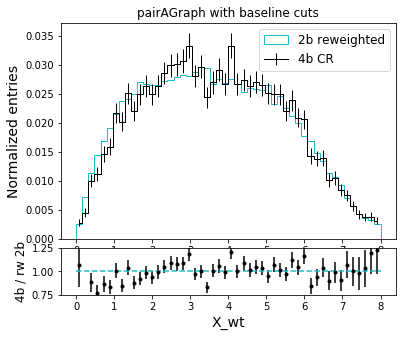

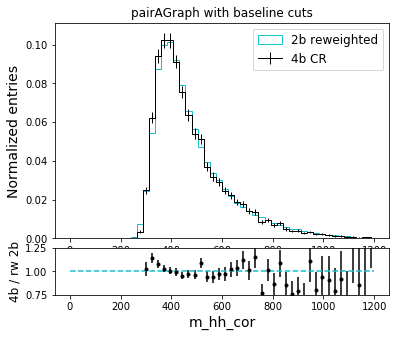

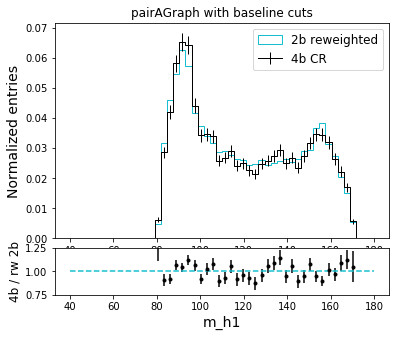

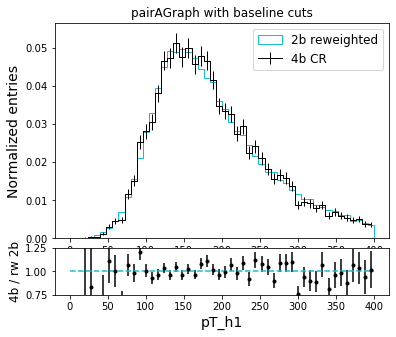

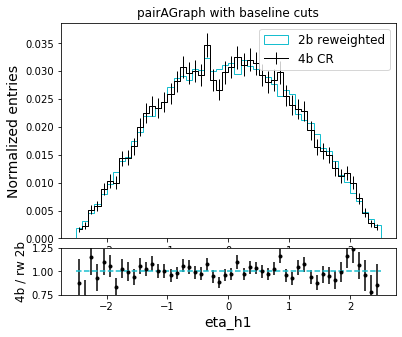

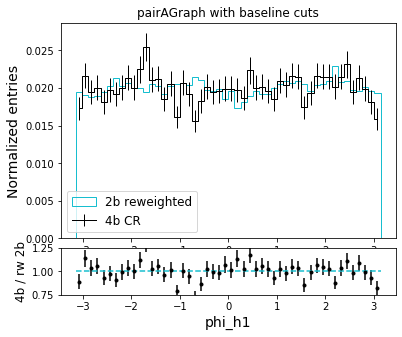

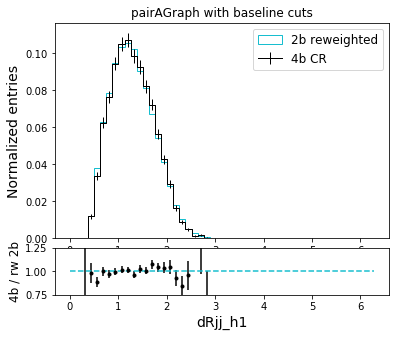

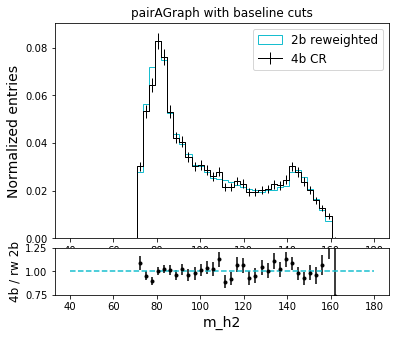

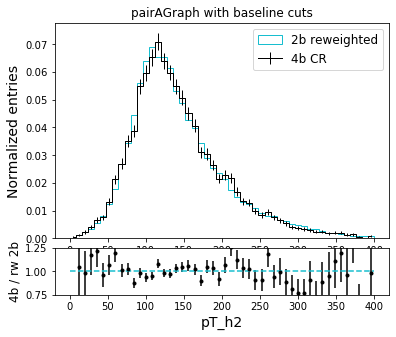

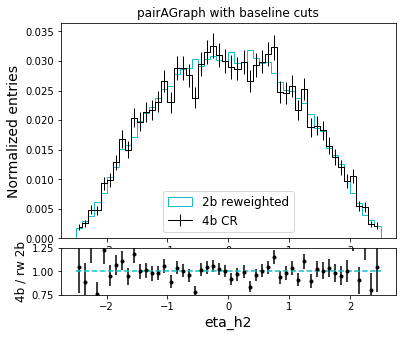

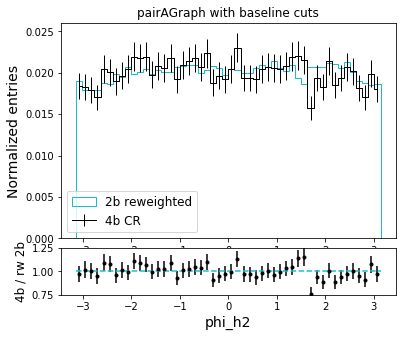

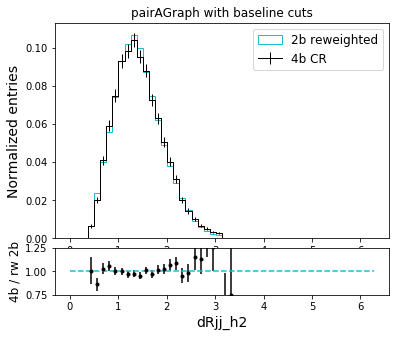

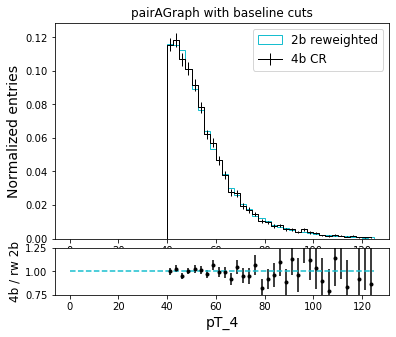

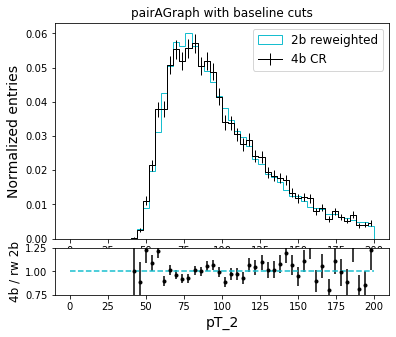

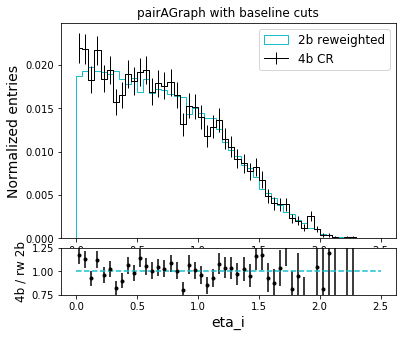

../code/plotting.py:760: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3369: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


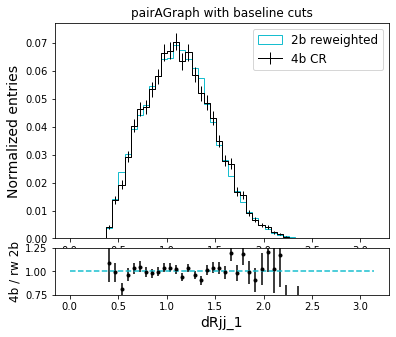

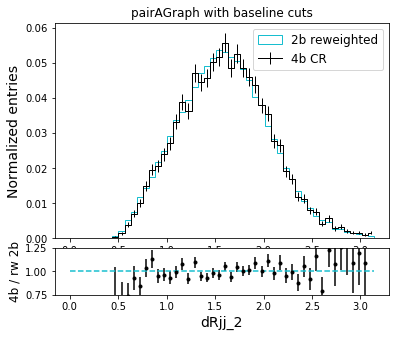

In [20]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==2),
            title='pairAGraph with baseline cuts: pre $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts')

In [29]:
bkgSubDir

'data_16_PFlow-MAY2019-5jets'

In [30]:
figDir=f'figures/{bkgSubDir}/xformer_train_SMNR_mc16ade/baselineCuts'

78469


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


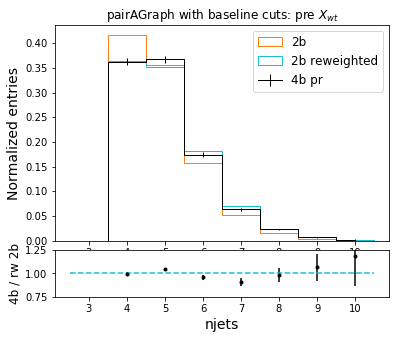

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


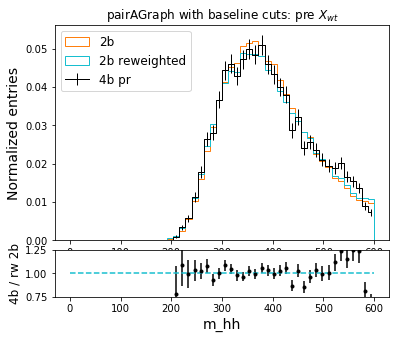

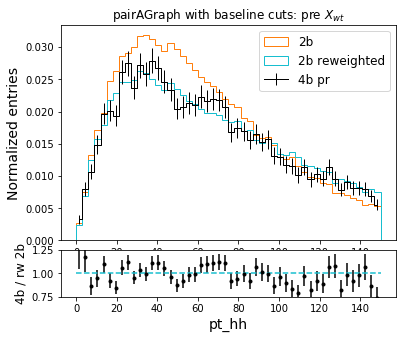

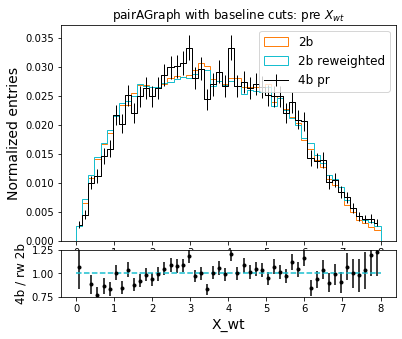

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


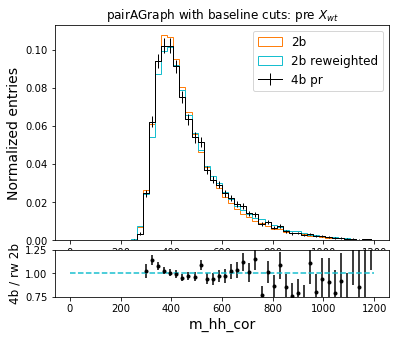

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


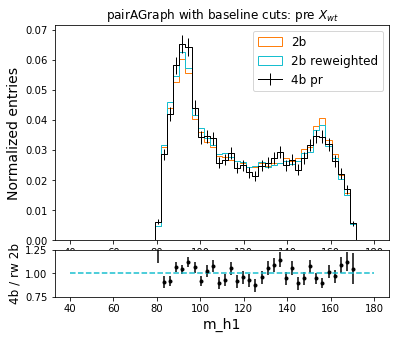

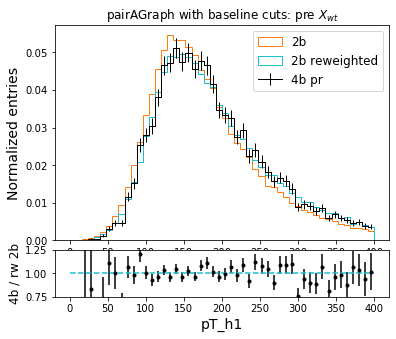

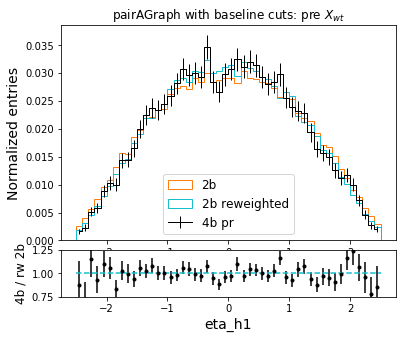

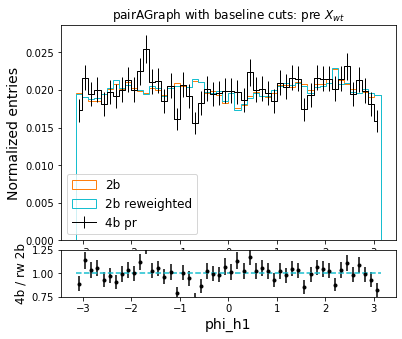

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


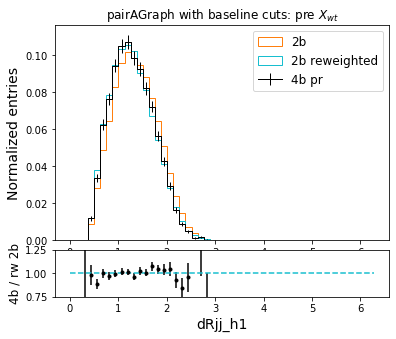

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


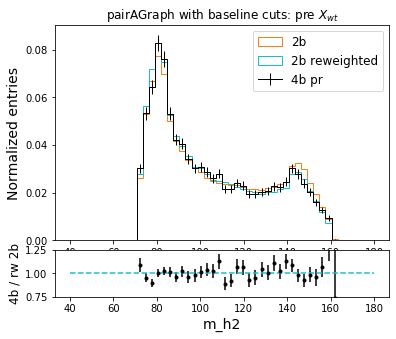

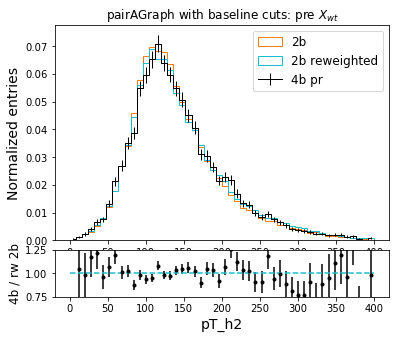

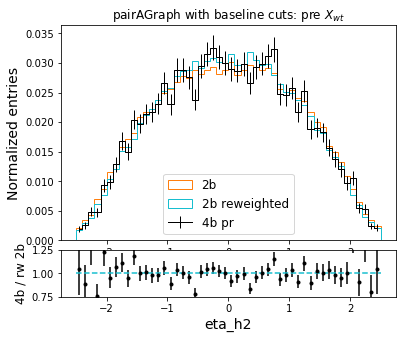

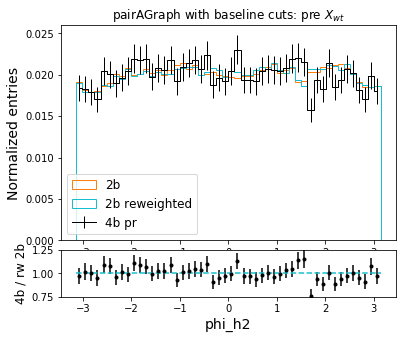

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


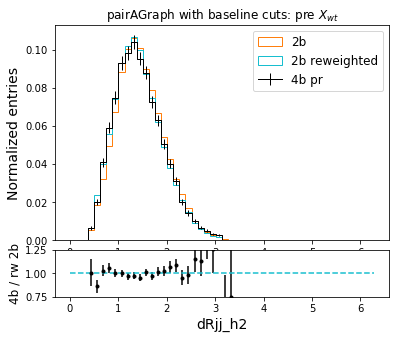

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


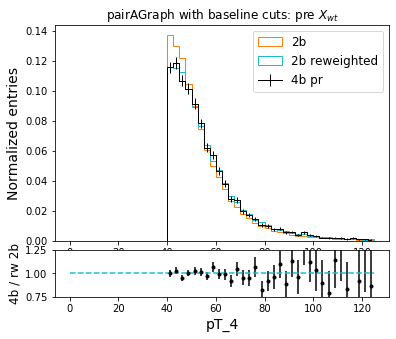

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


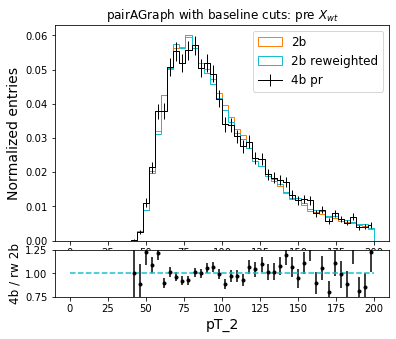

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


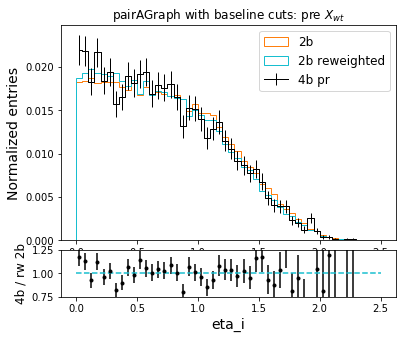

../code/plotting.py:760: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3369: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


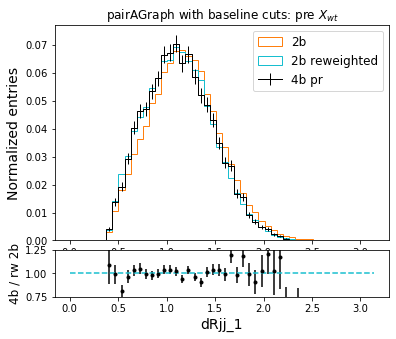

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


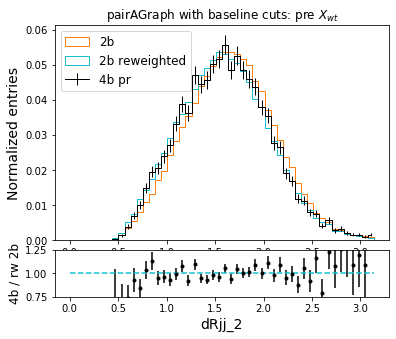

In [31]:
cf_1d_dists(bkg_df,drawUnweighted=True,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==2),
            title='pairAGraph with baseline cuts: pre $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts',
            figDir=figDir,tag='_preXwt_CR')

67038


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


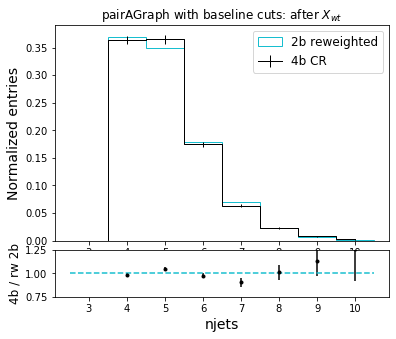

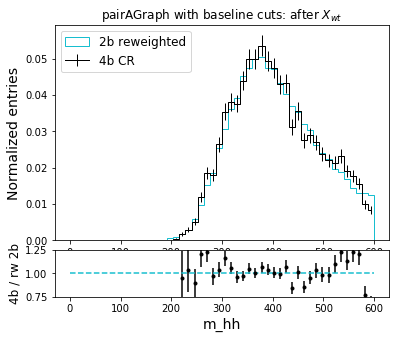

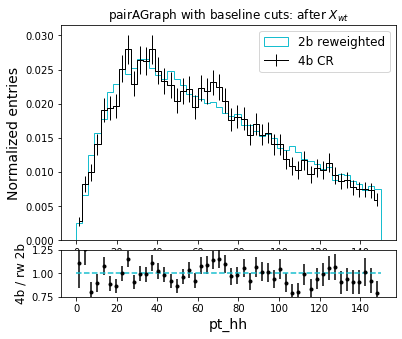

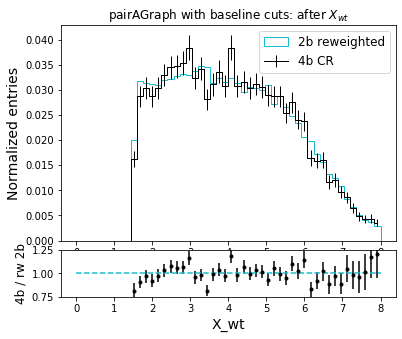

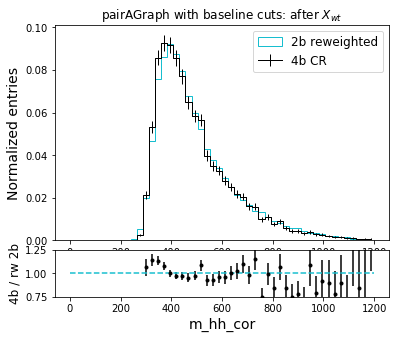

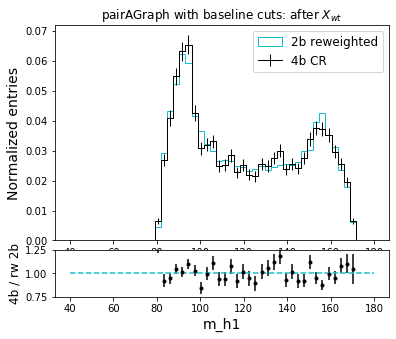

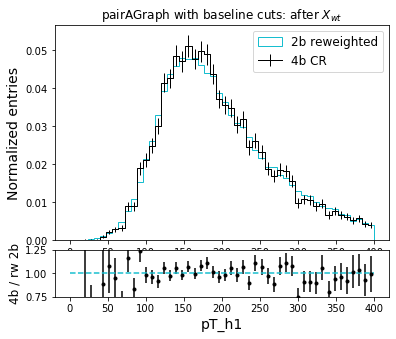

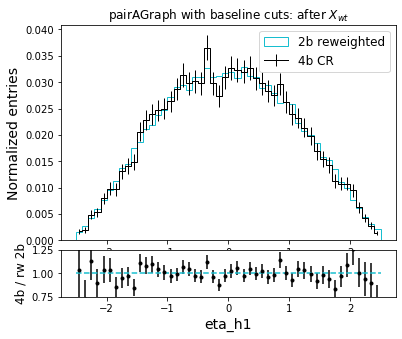

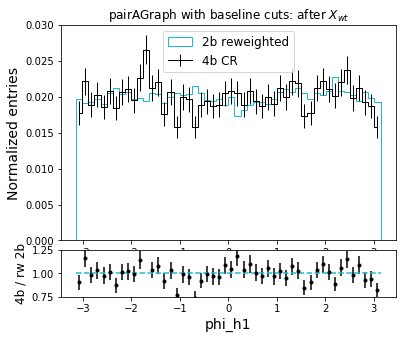

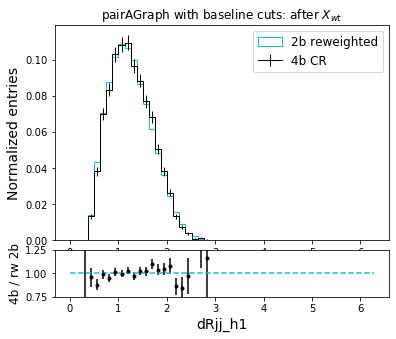

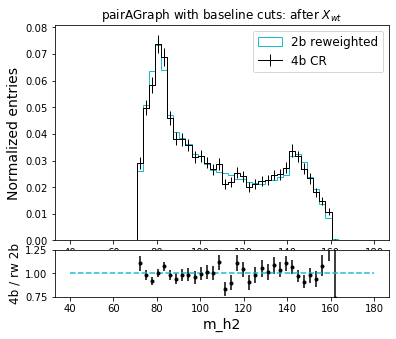

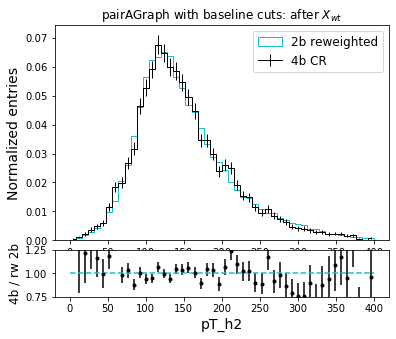

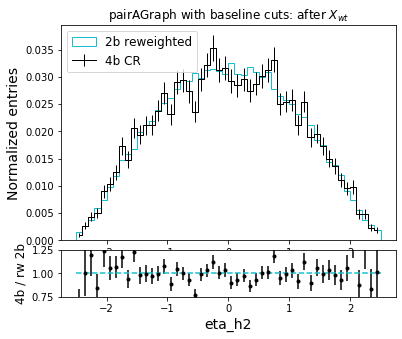

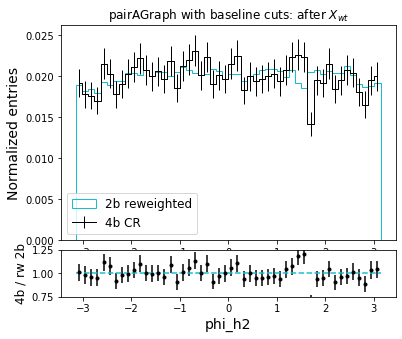

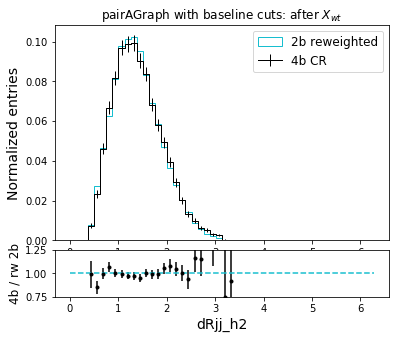

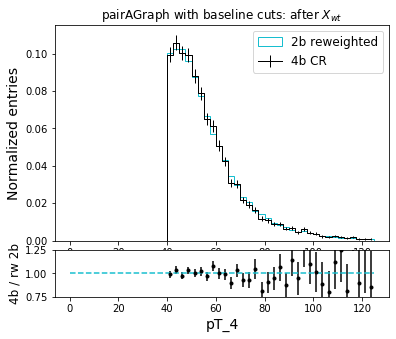

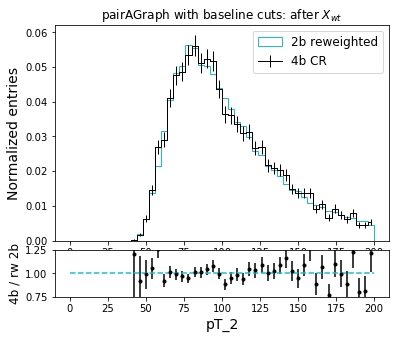

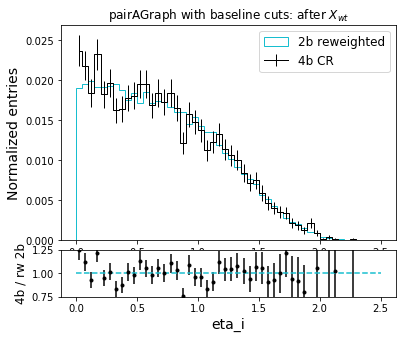

../code/plotting.py:760: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3369: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


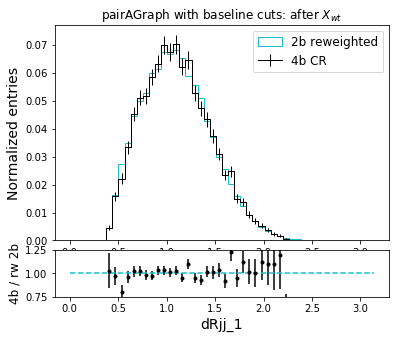

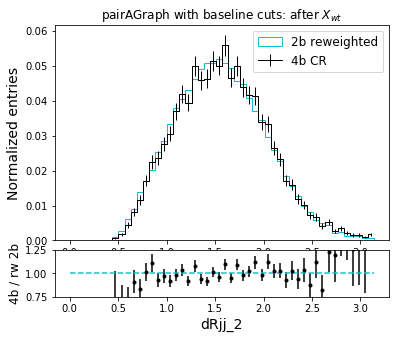

In [21]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==2)&(bkg_df.cut_Xwt),
            title='pairAGraph with baseline cuts: after $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts')

67038


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


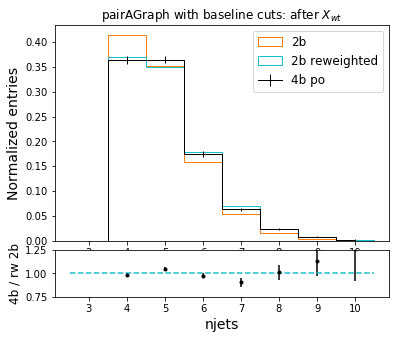

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


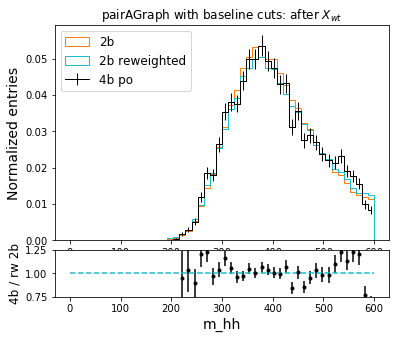

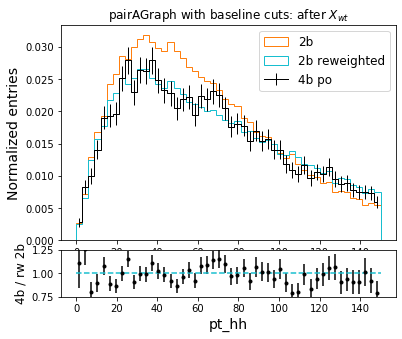

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


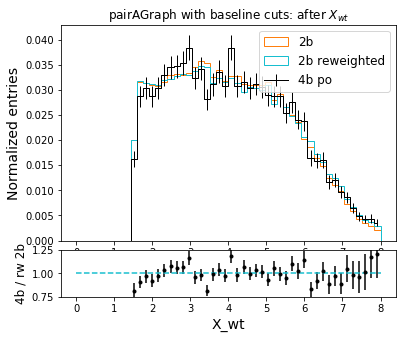

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


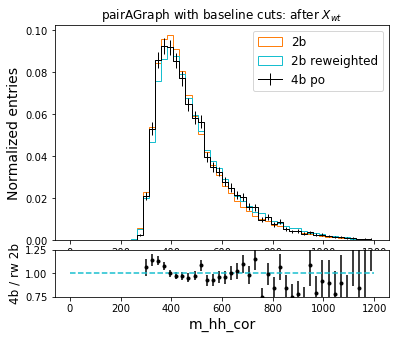

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


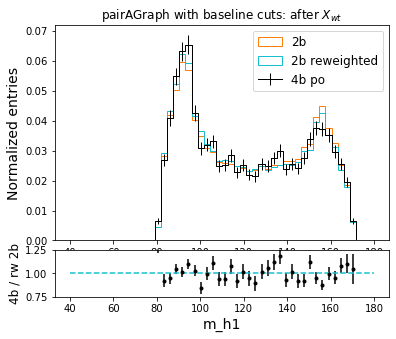

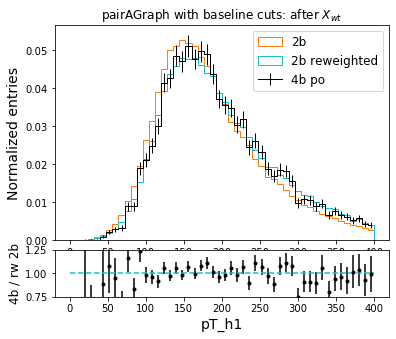

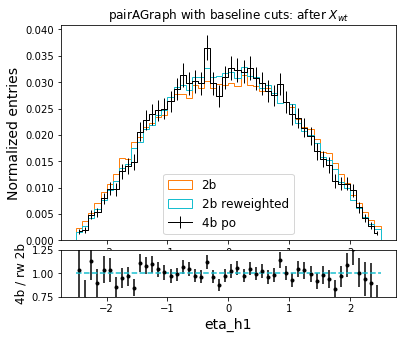

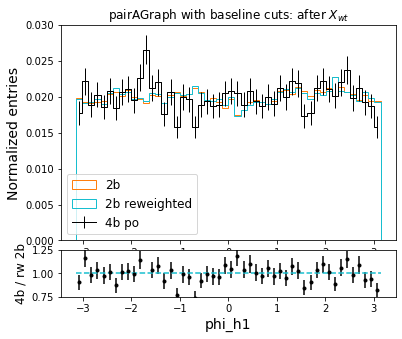

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


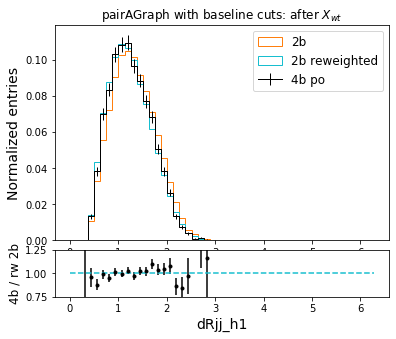

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


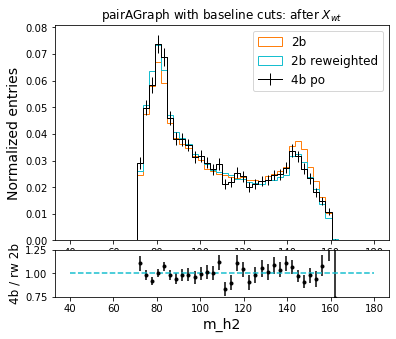

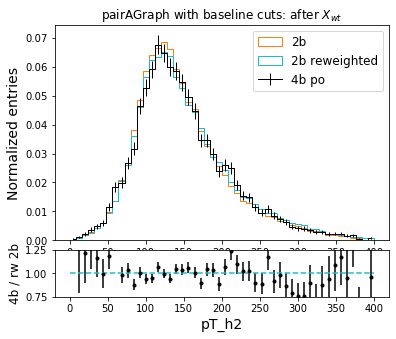

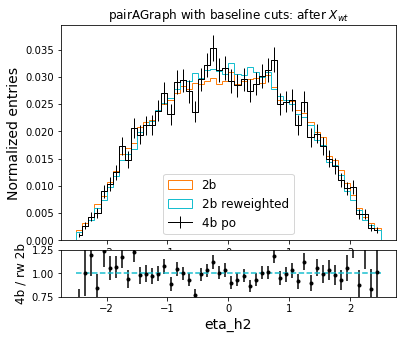

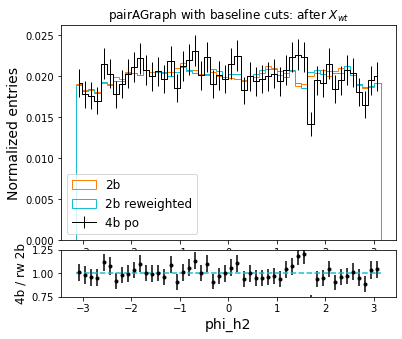

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


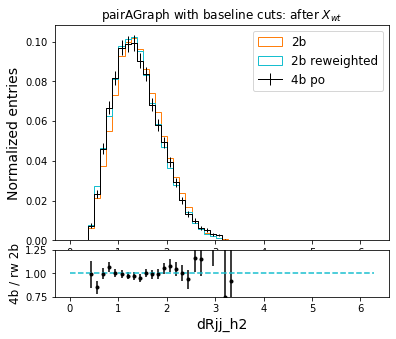

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


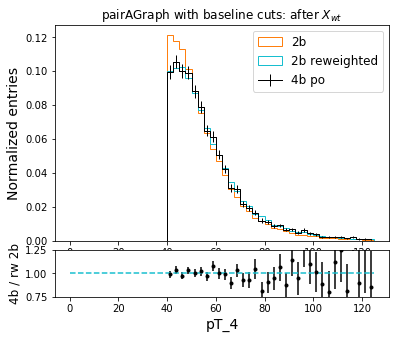

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


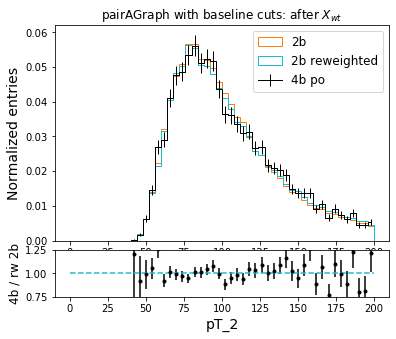

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


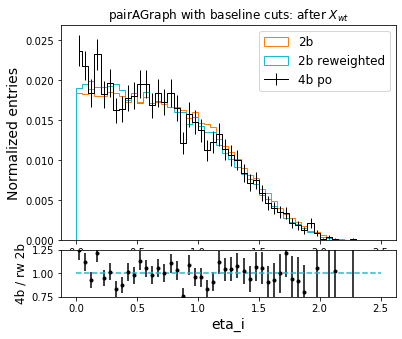

../code/plotting.py:760: RuntimeWarning: divide by zero encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3369: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


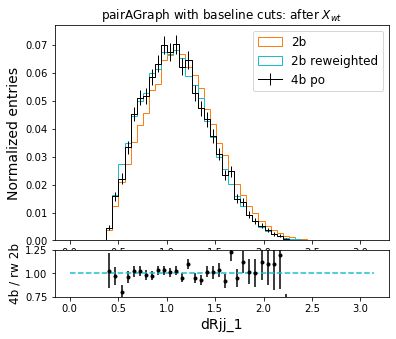

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


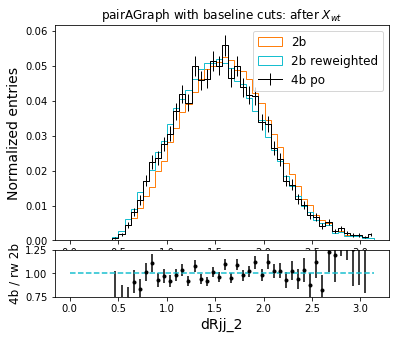

In [32]:
cf_1d_dists(bkg_df,drawUnweighted=True,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==2)&(bkg_df.cut_Xwt),
            title='pairAGraph with baseline cuts: after $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts',
            figDir=figDir,tag='_postXwt_CR')

40923


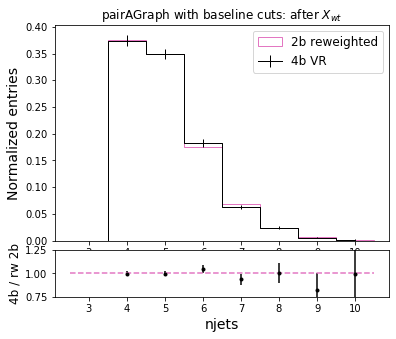

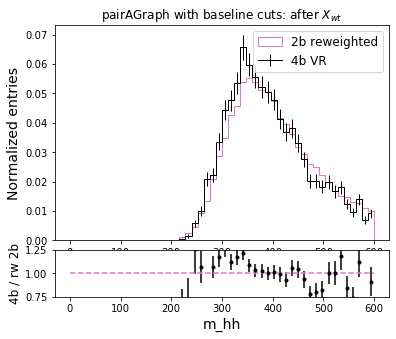

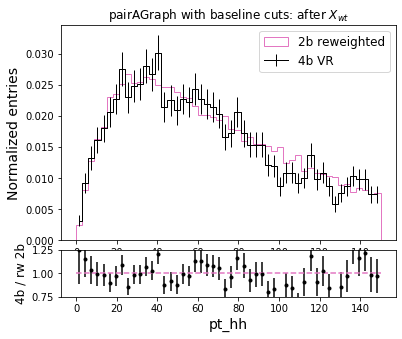

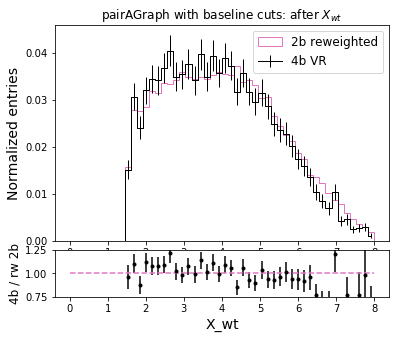

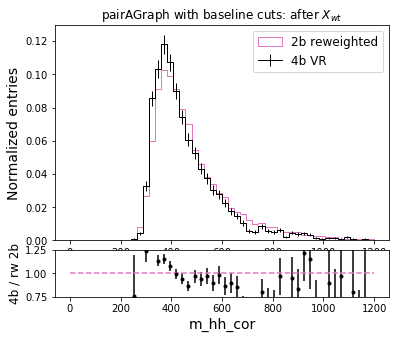

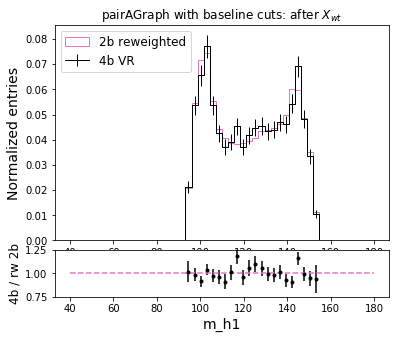

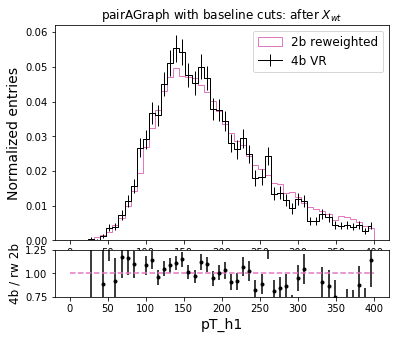

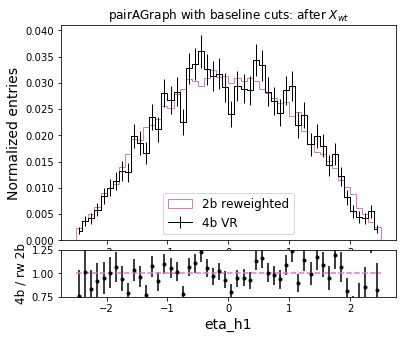

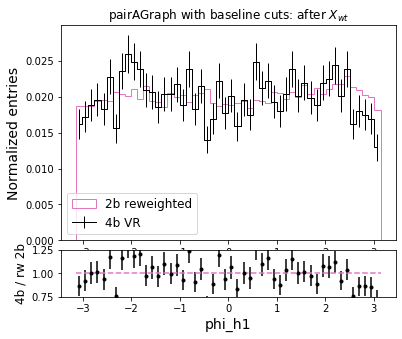

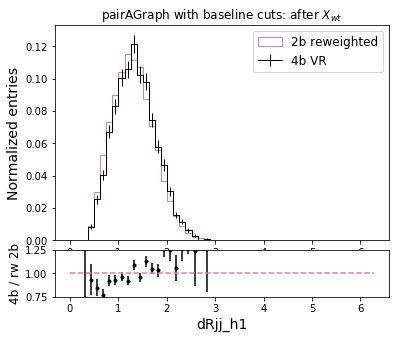

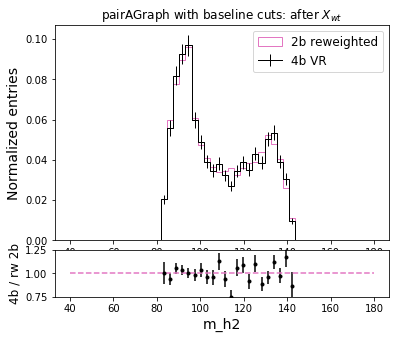

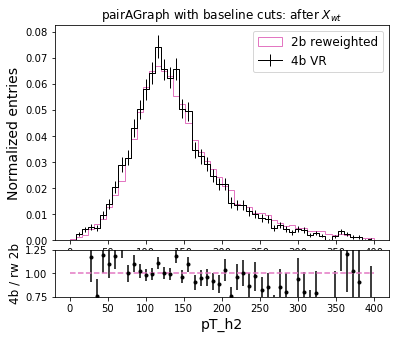

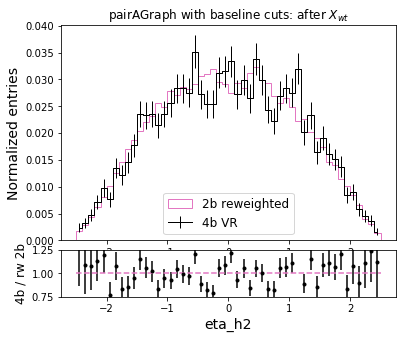

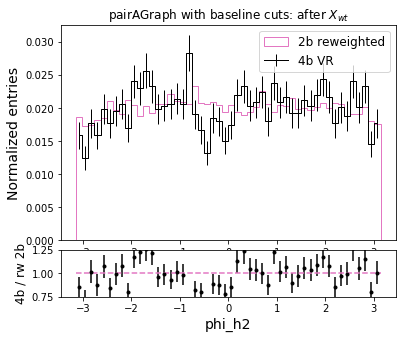

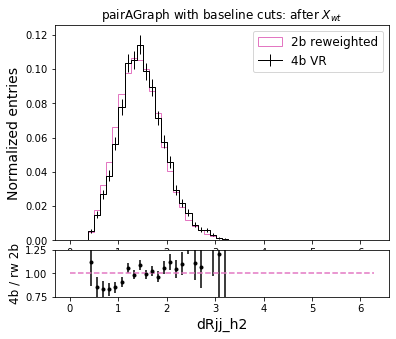

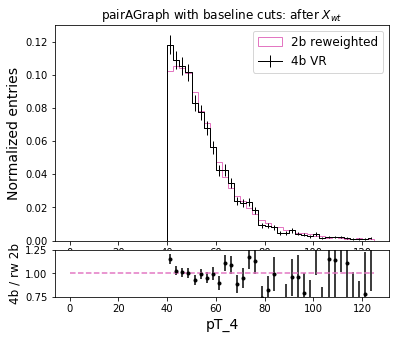

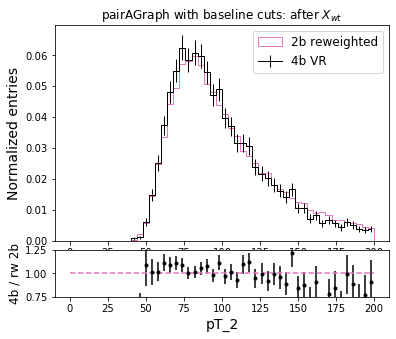

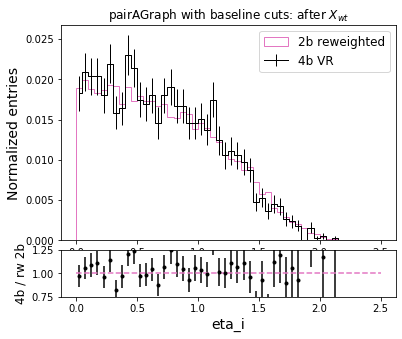

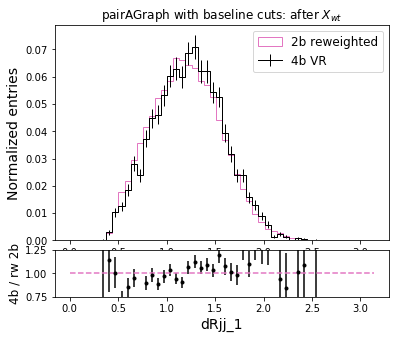

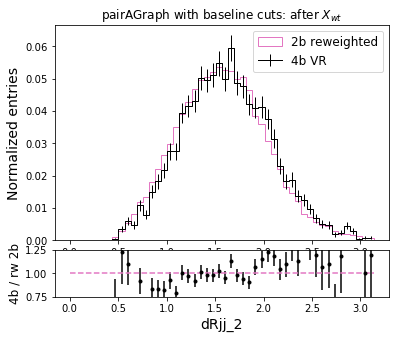

In [23]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==1)&(bkg_df.cut_Xwt),
            color_2b='C6',tag='_VR',
            title='pairAGraph with baseline cuts: after $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts')

40923


../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


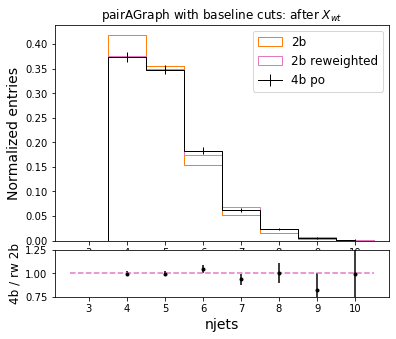

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


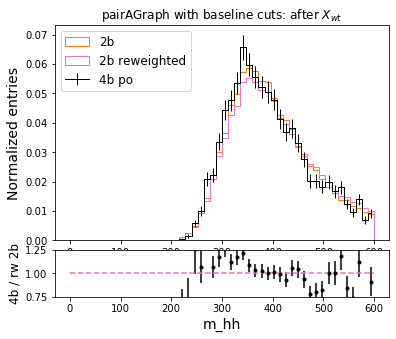

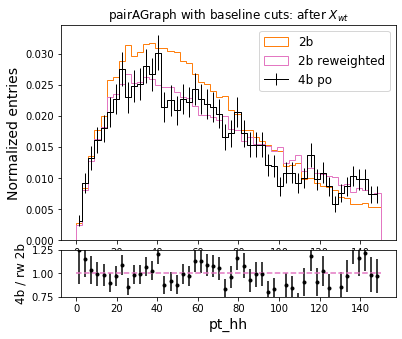

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


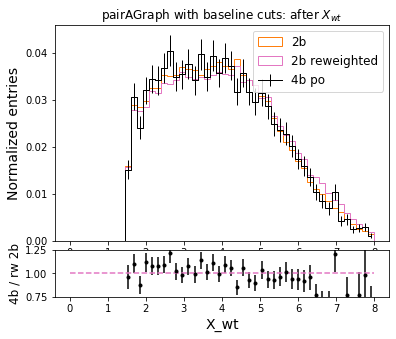

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


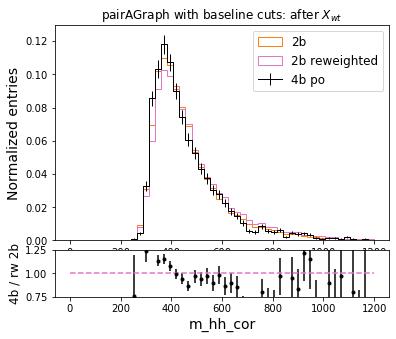

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


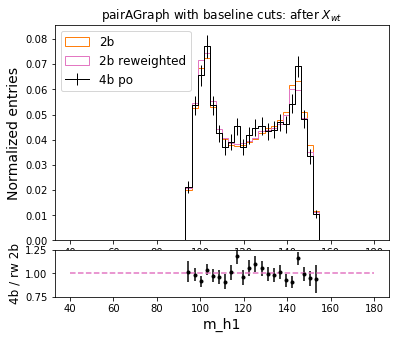

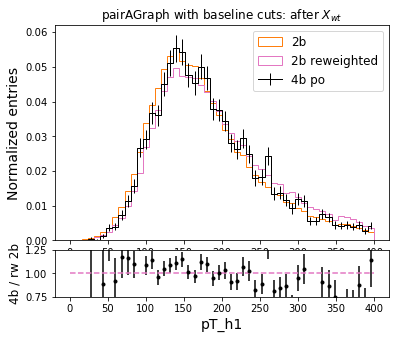

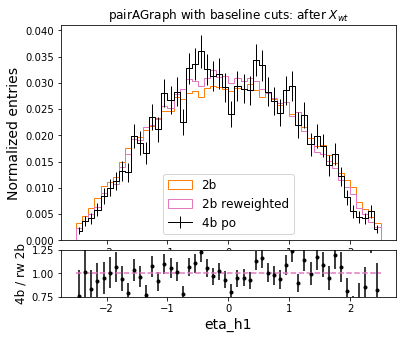

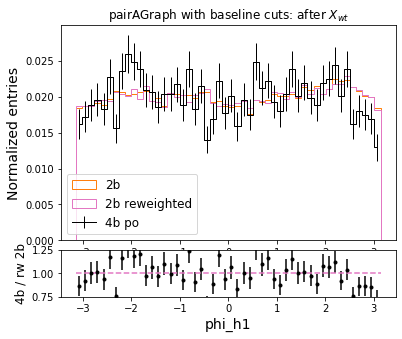

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


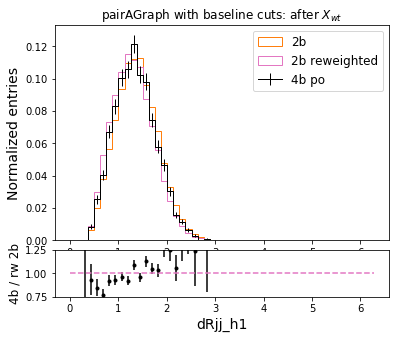

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


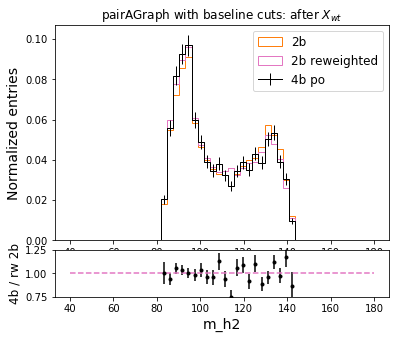

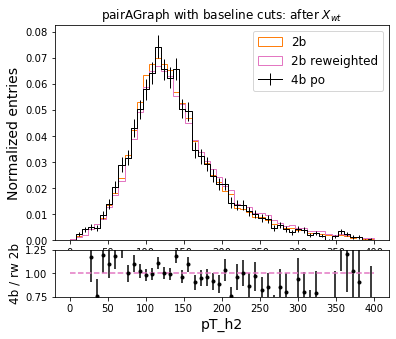

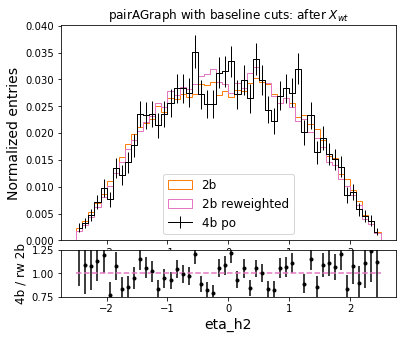

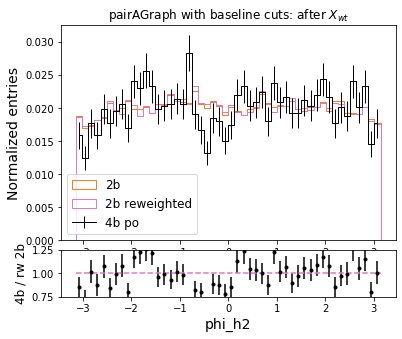

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


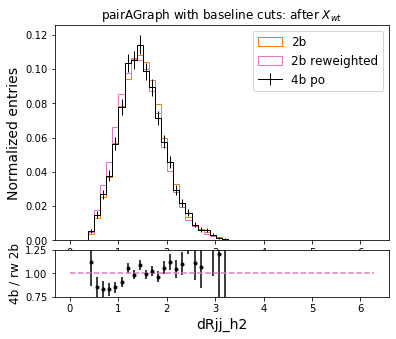

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


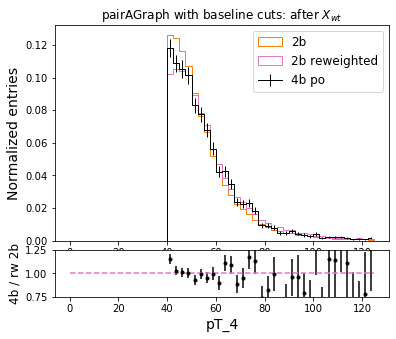

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


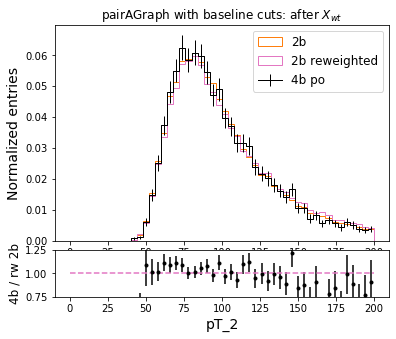

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


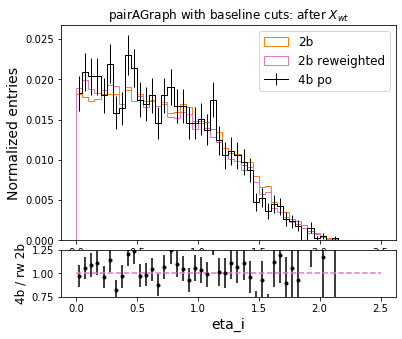

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


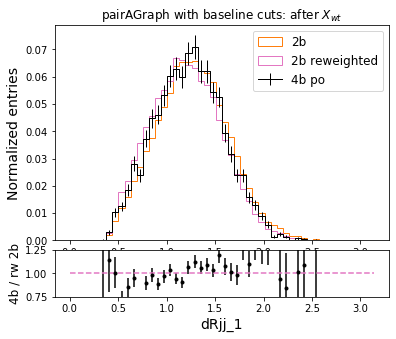

../code/plotting.py:760: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(x, n_4b / (N_4b * n_2b), yerr=np.sqrt(n_4b) / (N_4b * n_2b), fmt='.', color='k')


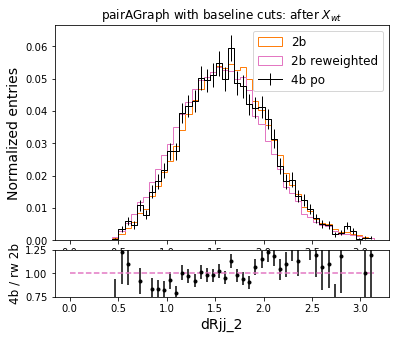

In [34]:
cf_1d_dists(bkg_df,drawUnweighted=True,mask=bkg_df.cut_deta_hh&(bkg_df.kinematic_region==1)&(bkg_df.cut_Xwt),
            color_2b='C6',title='pairAGraph with baseline cuts: after $X_{wt}$',
            chi2Only=False,w2b='w_2b_stdCuts',
            figDir=figDir,tag='_postXwt_VR')

As before, it seems like there are some cases where the reweighting is making the $m_{hh}$ distribution worse.

Ok, this is great news!

1. I know how to get (at least reasonable) limits for pairAGraph now
2. This is further motivation to want to look into methods that can directly extrapolate across the SR in 4b data
3. If the issue is getting 2b to look more like 4b, maybe I should try 2b same HC as a better place to start from? (To do this, I'll need to re-run the NNTs, but I think this was a step that I was wanting to do anyway to make PC b-tagging categories)
4. Should I repeat these studies with the baseline analysis?
5. If I left the other cuts in but took $\Delta \eta$ out, how does it look??

In [ ]:
modelDir = f"nn_rw/data_16_MDpT_CR"
if not os.path.exists(modelDir):
    os.mkdir(modelDir)
ws = getNNweights(bkg_df[bkg_df.MDpT],train=True,kinematic_region=2,modelDir=modelDir,
                    nHidden=20,patience=2,key='w_2b_MDpT')

bkg_df.loc[bkg_df.MDpT,'w_2b_MDpT']=ws

In [ ]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.MDpT&(bkg_df.kinematic_region==2),
            title='pairAGraph after MDpT',chi2Only=False,w2b='w_2b_MDpT')

Ok, now I'm not so sure, but I think it looks (almost) as good as the baseline cuts... I'm going to go with it and derive a systematic, and try to do a 2d fit (tomorrow).

In [ ]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_Xwt&bkg_df.MDpT&(bkg_df.kinematic_region==2),
            title='pairAGraph after $X_{wt}$, w/o $\Delta \eta_{hh}$ cut',chi2Only=False,w2b='w_2b_MDpT')

In [ ]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_Xwt&bkg_df.MDpT&(bkg_df.kinematic_region==1),
            title='pairAGraph after $X_{wt}$, w/o $\Delta \eta_{hh}$ cut',chi2Only=False,w2b='w_2b_MDpT',
            tag='_VR',color_2b='C6')

Ooooh, this is horrible extrapolation! What if I include the $\Delta \eta_{hh}$ cut when I reweight?

In [ ]:
cf_1d_dists(bkg_df,drawUnweighted=False,mask=bkg_df.cut_Xwt&bkg_df.cut_deta_hh&(bkg_df.kinematic_region==1),
            title='pairAGraph with baseline cuts after $X_{wt}$',chi2Only=False,w2b='w_2b_stdCuts',
            tag='_VR',color_2b='C6')

This is going to be a *huge* systematic... does this mean pairAGraph is a no-go?

**Another idea:** Maybe this is b/c pairAGraph explicitly used # of b-tags in the training, so this is fucking up the reweighting which I think to some extent relies on the assumption that the 2b kinematics isn't that far from the 4b kinematics.

To me, this seems like good motivation to *revisit* the studies where I put the 2bs in the same HC since it *seems* like we are now in a situation where we are limited by the discrepancies b/w 2b and 4b events.

**Plan:** I'll ask Rafael tomorrow!

**Big picture:** pairAGraph is making it *more* difficult to do a background estimate than our current methods.

Is there something else I should try, or should I jump ship at this point?
